In [69]:
from keras.layers import Dropout, Dense, Flatten, Activation, Input, Embedding, Dot
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall, AUC

from pylab import rcParams

import matplotlib.pyplot as plt
import pandas as pd


In [19]:
ratings_df = pd.read_csv('./data/movies/ratings.csv').drop('timestamp', axis=1)
movies_df = pd.read_csv('./data/movies/movies.csv')

In [ ]:
ratings_df.head()

In [20]:
movies_df.head()

In [23]:
users = ratings_df.userId.unique()
movies = ratings_df.movieId.unique()

In [24]:
userid2idx = {o: i for i, o in enumerate(users)}
movieid2idx = {o: i for i, o in enumerate(movies)}
df = ratings_df.copy(deep=True)
df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])

In [31]:
df[['userId', 'movieId']]

,userId,movieId
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
99999,670,7005
100000,670,4771
100001,670,1329
100002,670,1331


In [82]:
train, test = train_test_split(df, test_size=0.20)

In [45]:
n_latent_factors = 64

Model 1: just embeddings

In [118]:
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())
user_input = Input(shape=(1,), dtype='int64')
user_embedding = Embedding(n_users, n_latent_factors)(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)

movie_input = Input(shape=(1,), dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors)(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

sim = Dot(axes=1)([user_vec, movie_vec])
emb_model = Model([user_input, movie_input], sim)
emb_model.compile(loss='mse')

In [83]:
test

,userId,movieId,rating
75287,521,1467,2.5
44514,311,816,4.0
39446,286,1597,4.5
48792,357,143,5.0
60686,440,673,4.5
...,...,...,...
27373,198,5188,3.5
17039,110,324,3.0
51091,378,332,3.5
51962,379,1591,3.5


In [119]:
emb_history = emb_model.fit([train.userId, train.movieId], train.rating,
                            validation_data=([test.userId, test.movieId], test.rating),
                            batch_size=128, epochs=15, verbose=1)

Epoch 1/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 13.6458 - val_loss: 12.5280
Epoch 2/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 10.8464 - val_loss: 5.9876
Epoch 3/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.0938 - val_loss: 3.6498
Epoch 4/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.1204 - val_loss: 2.6996
Epoch 5/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.2772 - val_loss: 2.2362
Epoch 6/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8469 - val_loss: 1.9658
Epoch 7/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5616 - val_loss: 1.7917
Epoch 8/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3758 - val_loss: 1.6743
Epoch 9/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.2511 - val_loss: 1.5887
Epoch 10/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1370 - val_loss: 1.5255
Epoch 11/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0628 - val_loss: 1.4741
Epoch 12/15
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/s

In [120]:
def plot_loss(_history, saving_path: str = None):
    rcParams['figure.figsize'] = 10, 5
    plt.plot(_history.history['loss'], 'g')
    plt.plot(_history.history['val_loss'], 'b')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)

    if saving_path is not None:
        plt.savefig(saving_path)

    plt.show()


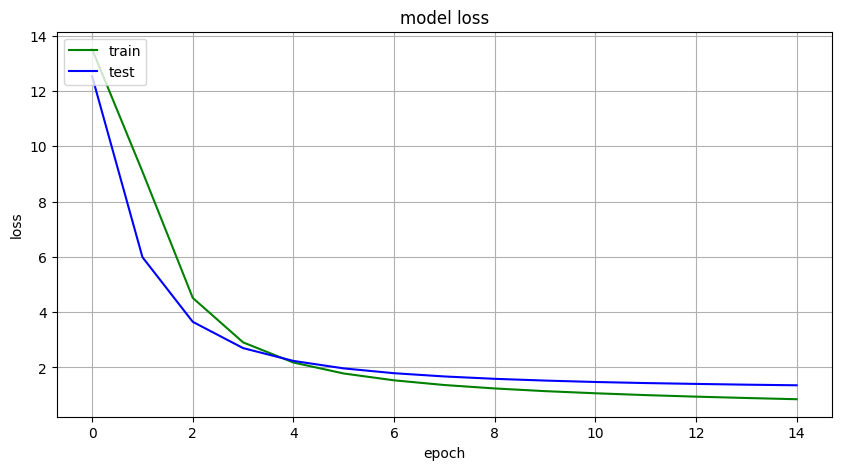

In [121]:
plot_loss(emb_history, saving_path='./checkpoints/plots/embedded_recs_traint_test_loss.png')

Model 2: NN filtration

In [127]:
user_input = Input(shape=(1,), dtype='int64')
user_embedding = Embedding(n_users, n_latent_factors)(user_input)
user_vec = Flatten()(user_embedding)
user_vec = Dropout(0.5)(user_vec)


movie_input = Input(shape=(1,), dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors)(movie_input)
movie_vec = Flatten()(movie_embedding)
movie_vec = Dropout(0.5)(movie_vec)

sim = Dot(axes=1)([user_vec, movie_vec])

nn_inp = Dense(96, activation='relu')(sim)
nn_inp = Dense(1, activation='relu')(nn_inp)

nn_model = Model([user_input, movie_input], nn_inp)
nn_model.compile(loss='mse')

In [126]:
nn_history = nn_model.fit([trainX.userId, trainX.movieId], train.rating,
                           validation_data=([testX.userId, testX.movieId], test.rating),
                           batch_size=128, epochs=50, verbose=1)

Epoch 1/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 13.6812 - val_loss: 13.6027
Epoch 2/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 13.6891 - val_loss: 13.6027
Epoch 3/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 13.7127 - val_loss: 13.6027
Epoch 4/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 13.7227 - val_loss: 13.6027
Epoch 5/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 13.7040 - val_loss: 13.6027
Epoch 6/50
361/626 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 13.6716


KeyboardInterrupt



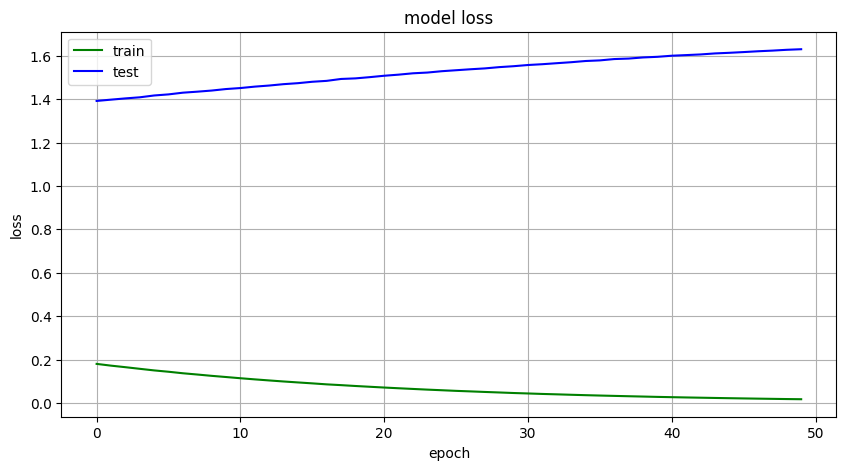

In [81]:
plot_loss(nn_history, saving_path='./checkpoints/plots/nn_recs_traint_test_loss.png')